In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

In [3]:
# Manual regression function (already correct)
def fit_polynomial_manual(x, y, degree):
    X = np.vander(x, degree + 1, increasing=True)
    coeffs = np.linalg.inv(X.T @ X) @ (X.T @ y)
    return coeffs

In [4]:
def predict_polynomial(x, coeffs):
    return sum(w * x**i for i, w in enumerate(coeffs))

In [5]:
# Predict with trend + seasonality
def predict_with_seasonality(df, target_col, degree=2, months_ahead=72):
    x = df['TimeIndex'].values
    y = df[target_col].values

    coeffs = fit_polynomial_manual(x, y, degree)
    x_future = np.arange(x.max() + 1, x.max() + months_ahead + 1)

    # Monthly seasonal pattern
    monthly_avg = df.groupby('Month')[[target_col]].mean()
    seasonal_pattern = monthly_avg[target_col].values

    y_trend = predict_polynomial(x_future, coeffs)
    y_seasonal = np.tile(seasonal_pattern, months_ahead // 12 + 1)[:months_ahead]
    y_future = y_trend + (y_seasonal - np.mean(seasonal_pattern))

    return x_future, y_future

In [6]:
# Plot and save + show
def plot_forecast(df, target_col, x_future, y_future, district):
    x = df['TimeIndex']
    y = df[target_col]

    start_year = df['Year'].min()
    all_x = np.concatenate([x, x_future])
    time_labels = [f"{start_year + t//12}-{(t%12)+1:02}" for t in all_x]

    plt.figure(figsize=(12, 5))
    plt.plot(x, y, 'o-', label=f'Actual {target_col}', markersize=3, alpha=0.6, color='grey')
    plt.plot(x_future, y_future, 'o-', label=f'Forecasted {target_col}', linewidth=1, color='skyblue')

    plt.xticks(
        ticks=np.linspace(all_x.min(), all_x.max(), 10, dtype=int),
        labels=[time_labels[i] for i in np.linspace(0, len(time_labels)-1, 10, dtype=int)],
        rotation=45
    )
    plt.xlabel("Time (Year-Month)")
    plt.ylabel(target_col)
    plt.title(f"{district} - {target_col} Forecast (Manual Regression + Seasonality)")
    plt.grid(True, linestyle=':')
    plt.legend()
    plt.tight_layout()

    # Save and show
    filename = f"forecast_plots/{district}_{target_col}_forecast.png"
    plt.savefig(filename)
    plt.show()
    


🔮 Forecasting for: Chitawan


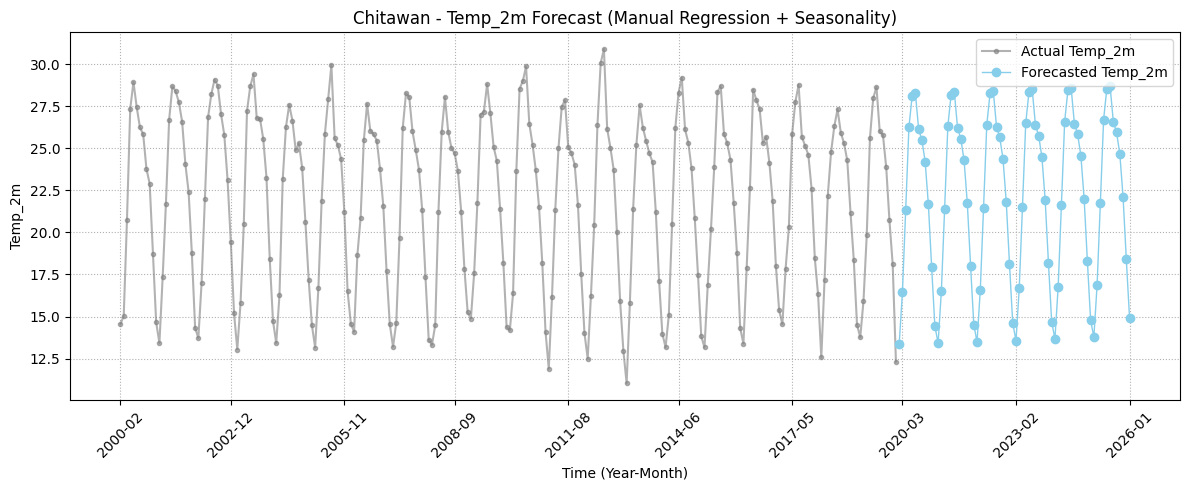

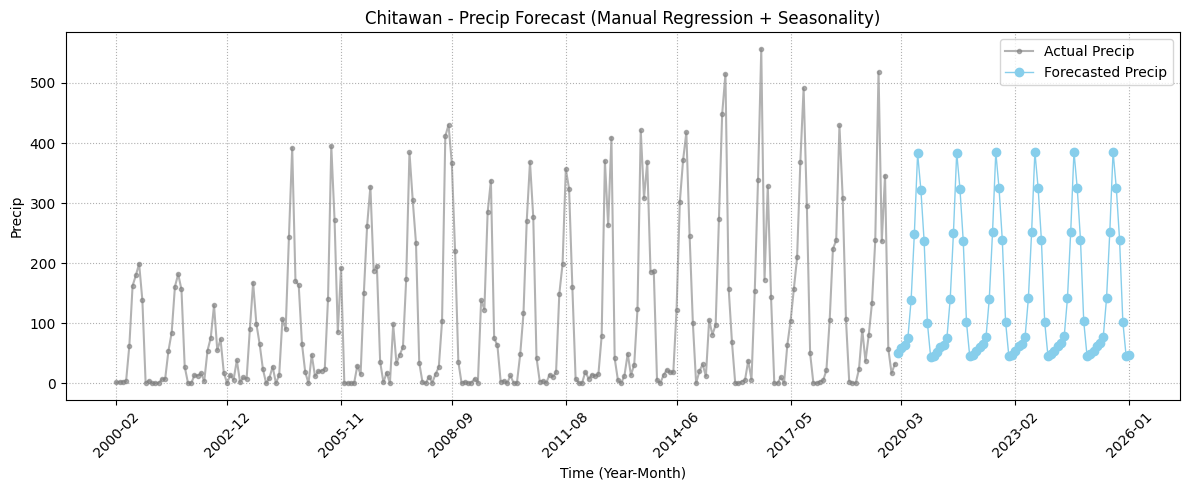


🔮 Forecasting for: Jhapa


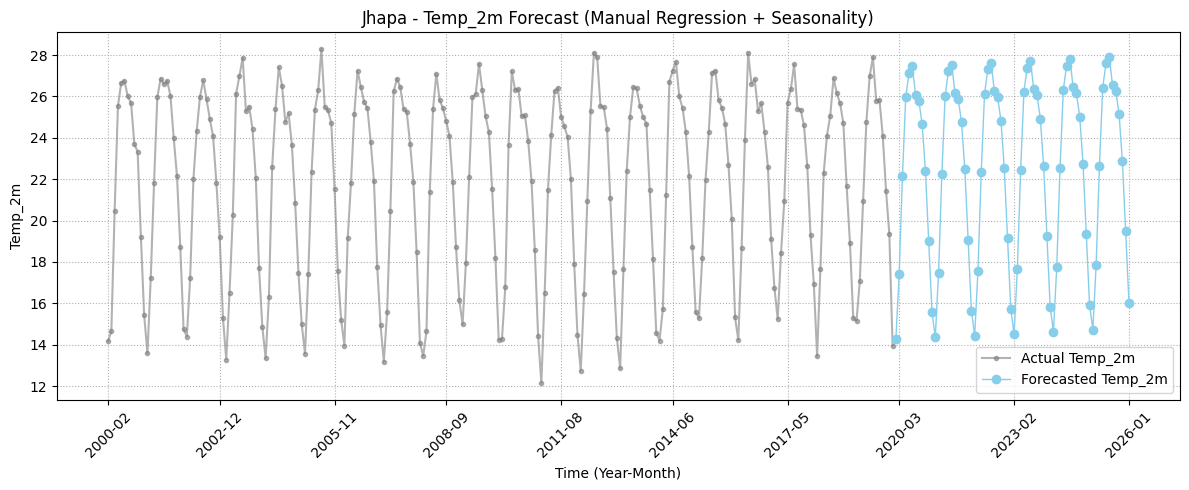

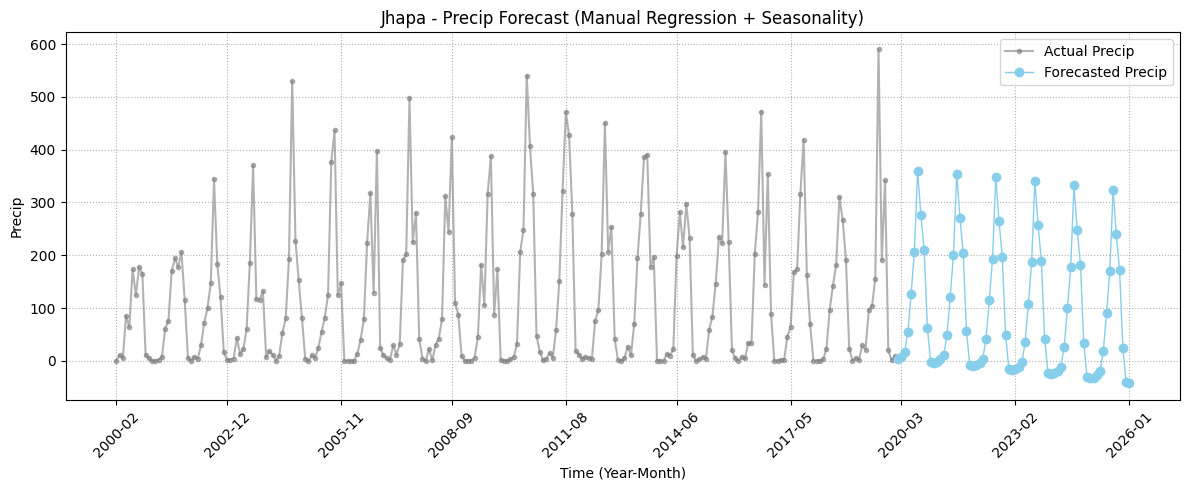


🔮 Forecasting for: Kabhre


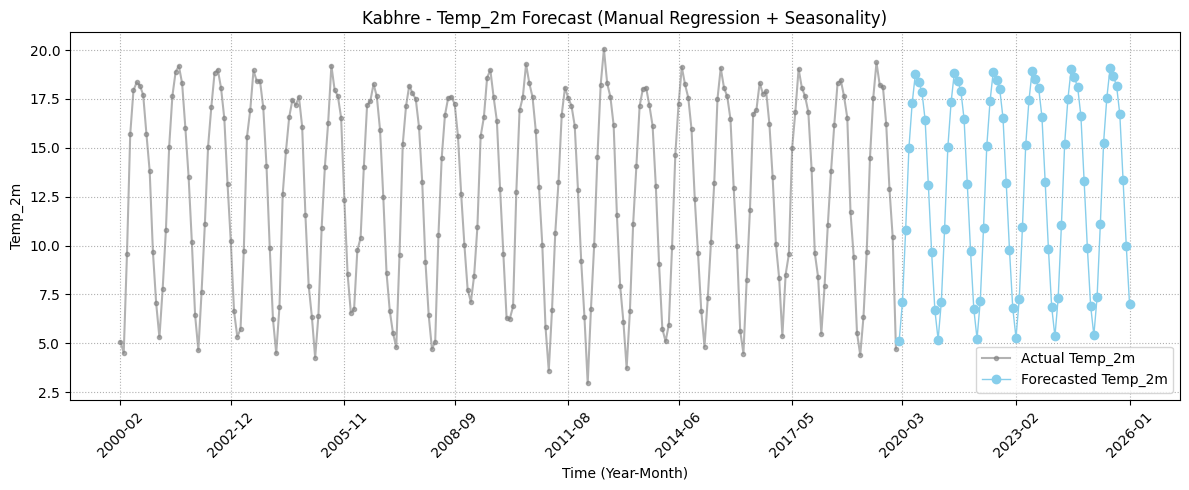

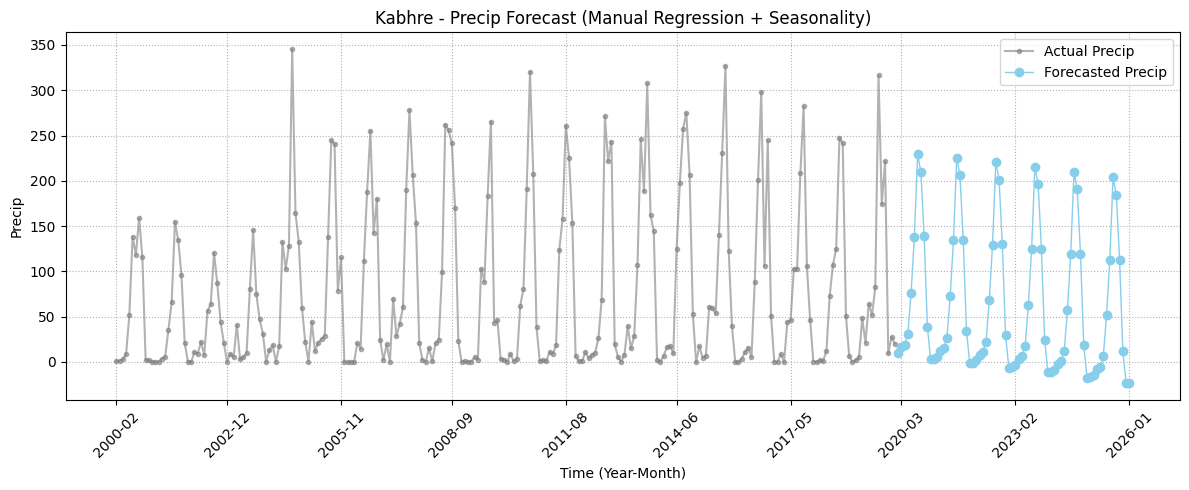


🔮 Forecasting for: Kathmandu


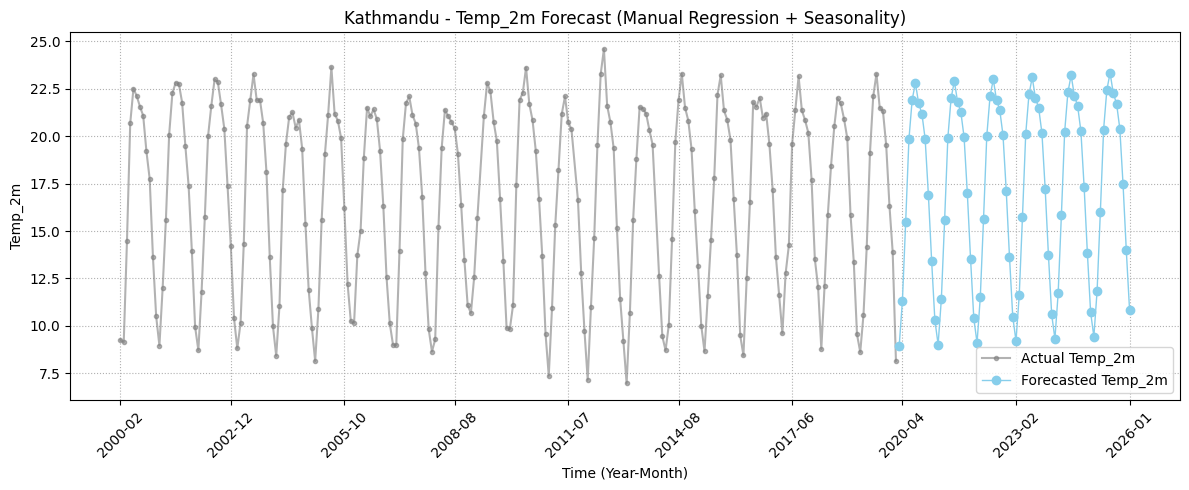

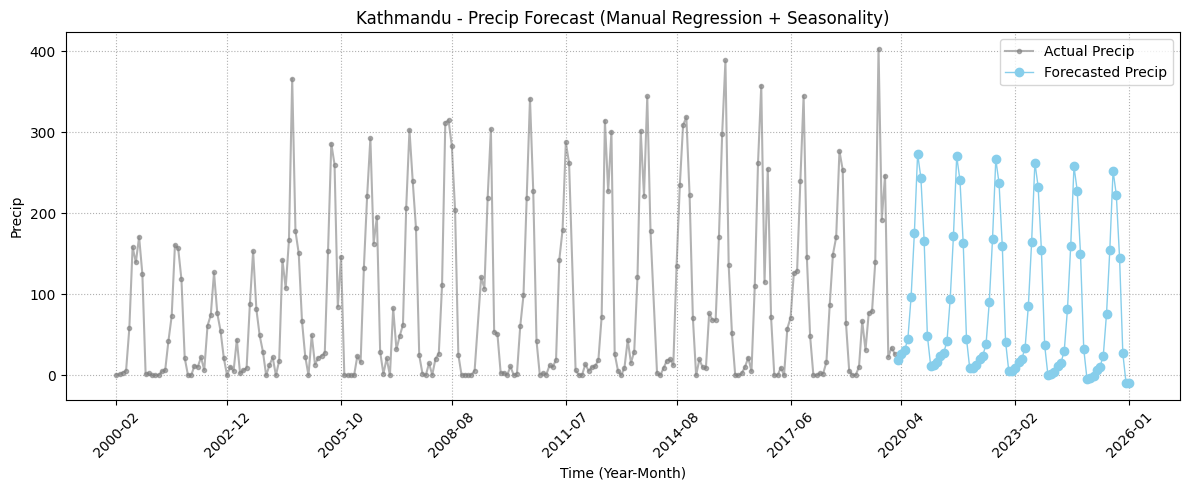


🔮 Forecasting for: Syangja


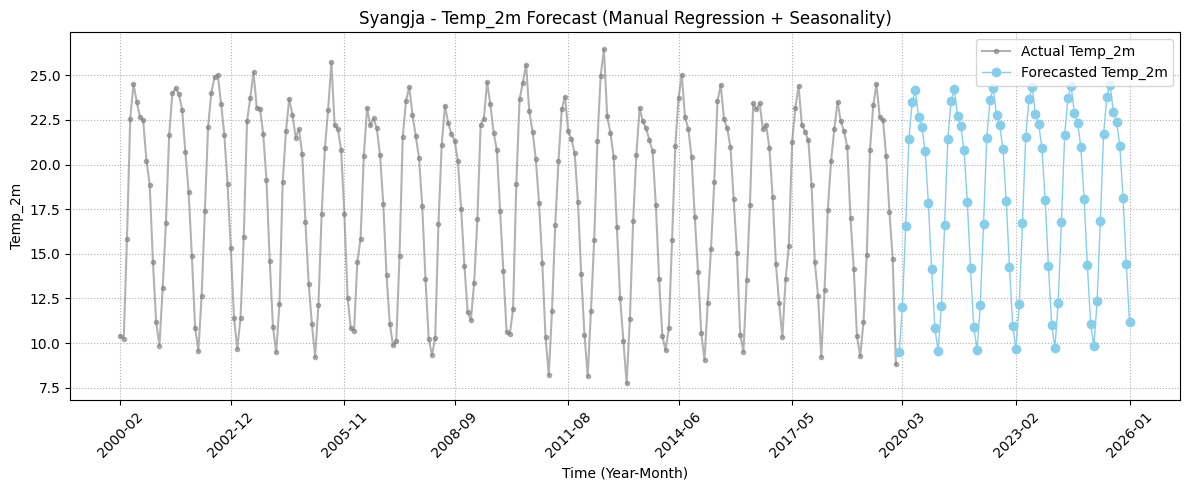

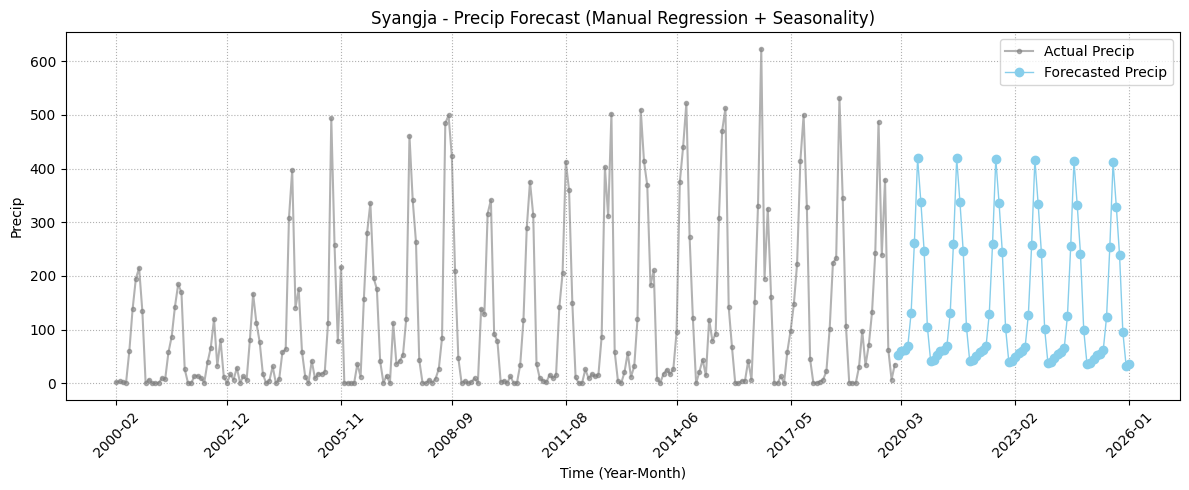

In [7]:
# Main loop
monthly_folder = "data/clean_data"
output_folder = "forecast_plots"
os.makedirs(output_folder, exist_ok=True)

months_ahead = 72

for file in os.listdir(monthly_folder):
    if file.endswith("_monthly.csv"):
        district = file.replace("_monthly.csv", "")
        print(f"\n🔮 Forecasting for: {district}")

        df = pd.read_csv(os.path.join(monthly_folder, file))
        df = df[(df['Year'] >= 2000) & (df['Year'] <= 2019)]
        df = df[['Year', 'Month', 'Temp_2m', 'Precip']].dropna()
        df['TimeIndex'] = (df['Year'] - df['Year'].min()) * 12 + df['Month']

        for col in ['Temp_2m', 'Precip']:
            x_future, y_future = predict_with_seasonality(df, col, degree=2, months_ahead=months_ahead)
            plot_forecast(df, col, x_future, y_future, district)
